In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import normalize
from sklearn.datasets import make_blobs, make_circles, make_moons
from sklearn.preprocessing import StandardScaler

In [3]:
data=pd.read_excel('/content/drive/MyDrive/NNFL data/Data_A2/data5.xlsx')

In [4]:
data[data.columns[-1]].unique()

array([1., 2., 3.])

In [5]:
data=data.sample(frac=1)
data.head()

,15.260,14.840,0.871,5.763,3.312,2.221,5.220,1.000
60,11.23,12.63,0.8840,4.902,2.879,2.269,4.703,1.0
20,14.11,14.26,0.8722,5.520,3.168,2.688,5.219,1.0
135,17.36,15.76,0.8785,6.145,3.574,3.526,5.971,2.0
46,14.99,14.56,0.8883,5.570,3.377,2.958,5.175,1.0
12,13.78,14.06,0.8759,5.479,3.156,3.136,4.872,1.0


In [6]:
data.to_numpy()

array([[11.23  , 12.63  ,  0.884 , ...,  2.269 ,  4.703 ,  1.    ],
       [14.11  , 14.26  ,  0.8722, ...,  2.688 ,  5.219 ,  1.    ],
       [17.36  , 15.76  ,  0.8785, ...,  3.526 ,  5.971 ,  2.    ],
       ...,
       [18.96  , 16.2   ,  0.9077, ...,  4.334 ,  5.75  ,  2.    ],
       [12.11  , 13.27  ,  0.8639, ...,  4.132 ,  5.012 ,  3.    ],
       [14.38  , 14.21  ,  0.8951, ...,  2.462 ,  4.956 ,  1.    ]])

In [7]:
class SMOModel:
    
    
    def __init__(self, X, y, C, kernel, alphas, b, errors):
        self.X = X               # training data vector
        self.y = y               # class label vector
        self.C = C               # regularization parameter
        self.kernel = kernel     # kernel function
        self.alphas = alphas     # lagrange multiplier vector
        self.b = b               # scalar bias term
        self.errors = errors     # error cache
        self._obj = []           # record of objective function value
        self.m = len(self.X)     # store size of training set

In [8]:
def gaussian_rbf_kernel(x, y, sigma=1):
    
    
    if np.ndim(x) == 1 and np.ndim(y) == 1:
         result = np.exp(- (np.linalg.norm(x - y, 7)) ** 2 / (2 * sigma ** 2))
    elif (np.ndim(x) > 1 and np.ndim(y) == 1) or (np.ndim(x) == 1 and np.ndim(y) > 1):
         result = np.exp(- (np.linalg.norm(x - y, 7, axis=1) ** 2) / (2 * sigma ** 2))
    elif np.ndim(x) > 1 and np.ndim(y) > 1:
         result = np.exp(- (np.linalg.norm(x[:, np.newaxis] - y[np.newaxis, :], 7, axis=2) ** 2) / (2 * sigma ** 2))
    #result=np.exp(-np.linalg.norm(x-y)**2 / (2 * (sigma ** 2)))
    return result 

def polynomial_kernel(X, Y):
    k = (1 + np.matmul(X, Y.transpose()))**7
    return k    

Testing kernels

In [9]:
x_len, y_len = 10, 5

In [10]:
polynomial_kernel(np.random.rand(x_len, 1), np.random.rand(y_len, 1)).shape == (x_len,y_len)

True

In [11]:
gaussian_rbf_kernel(np.random.rand(x_len, 1), np.random.rand(y_len, 1)).shape == (10,5)


True

In [12]:
# Objective function to optimize

def objective_function(alphas, target, kernel, X_train):
    '''
    `alphas`: vector of Lagrange multipliers
    `target`: vector of class labels (-1 or 1) for training data
    `kernel`: kernel function
    `X_train`: training data for model."""'''
    
    return np.sum(alphas) - 0.5 * np.sum((target[:, None] * target[None, :]) * kernel(X_train, X_train) * (alphas[:, None] * alphas[None, :]))


# Decision function

def decision_function(alphas, target, kernel, X_train, x_test, b):
    
    
    result = (alphas * target) @ kernel(X_train, x_test) - b
    return result

In [13]:
def plot_decision_boundary(model, ax, resolution=100, colors=('b', 'k', 'r'), levels=(-1, 0, 1)):
        """Plotting the model's decision boundary on the input axes object.
        Range of the decision boundary grid is determined by the training data.
        Returns the decision boundary grid and axes object (`grid`, `ax`)."""
        
        # Generate coordinate grid of shape [resolution x resolution]
       
        xrange = np.linspace(model.X[:,0].min(), model.X[:,0].max(), resolution)
        yrange = np.linspace(model.X[:,1].min(), model.X[:,1].max(), resolution)
        grid = [[decision_function(model.alphas, model.y,
                                   model.kernel, model.X[:,0:2],
                                   np.array([xr, yr]), model.b) for xr in xrange] for yr in yrange]
        grid = np.array(grid).reshape(len(xrange), len(yrange))
        
        
        # make a scatter plot of training data
        ax.contour(xrange, yrange, grid, levels=levels, linewidths=(1, 1, 1),
                   linestyles=('--', '-', '--'), colors=colors)
        ax.scatter(model.X[:,0], model.X[:,1],
                   c=model.y, cmap=plt.cm.viridis, lw=0, alpha=0.25)
        
        # Plot support vectors (non-zero alphas)
        
        mask = np.round(model.alphas, decimals=2) != 0.0
        ax.scatter(model.X[mask,0], model.X[mask,1],
                   c=model.y[mask], cmap=plt.cm.viridis, lw=1, edgecolors='k')
        
        return grid, ax

In [14]:
def take_step(i1, i2, model,eps):
    
    # Skip if chosen alphas are the same
    if i1 == i2:
        return 0, model
    
    alph1 = model.alphas[i1]
    alph2 = model.alphas[i2]
    y1 = model.y[i1]
    y2 = model.y[i2]
    E1 = model.errors[i1]
    E2 = model.errors[i2]
    s = y1 * y2
    
    # Compute L & H, the bounds on new possible alpha values
    if (y1 != y2):
        L = max(0, alph2 - alph1)
        H = min(model.C, model.C + alph2 - alph1)
    elif (y1 == y2):
        L = max(0, alph1 + alph2 - model.C)
        H = min(model.C, alph1 + alph2)
    if (L == H):
        return 0, model

    # Compute kernel & 2nd derivative eta
    k11 = model.kernel(model.X[i1], model.X[i1])
    k12 = model.kernel(model.X[i1], model.X[i2])
    k22 = model.kernel(model.X[i2], model.X[i2])
    eta = 2 * k12 - k11 - k22
    
    # Compute new alpha 2 (a2) if eta is negative
    if (eta < 0):
        a2 = alph2 - y2 * (E1 - E2) / eta
        # Clip a2 based on bounds L & H
        if L < a2 < H:
            a2 = a2
        elif (a2 <= L):
            a2 = L
        elif (a2 >= H):
            a2 = H
            
    # If eta is non-negative, move new a2 to bound with greater objective function value
    else:
        alphas_adj = model.alphas.copy()
        alphas_adj[i2] = L
        # objective function output with a2 = L
        Lobj = objective_function(alphas_adj, model.y, model.kernel, model.X) 
        alphas_adj[i2] = H
        # objective function output with a2 = H
        Hobj = objective_function(alphas_adj, model.y, model.kernel, model.X)
        if Lobj > (Hobj + eps):
            a2 = L
        elif Lobj < (Hobj - eps):
            a2 = H
        else:
            a2 = alph2
            
    # Push a2 to 0 or C if very close
    if a2 < 1e-8:
        a2 = 0.0
    elif a2 > (model.C - 1e-8):
        a2 = model.C
    
    # If examples can't be optimized within epsilon (eps), skip this pair
    if (np.abs(a2 - alph2) < eps * (a2 + alph2 + eps)):
        return 0, model
    
    # Calculate new alpha 1 (a1)
    a1 = alph1 + s * (alph2 - a2)
    
    # Update threshold b to reflect newly calculated alphas
    # Calculate both possible thresholds
    b1 = E1 + y1 * (a1 - alph1) * k11 + y2 * (a2 - alph2) * k12 + model.b
    b2 = E2 + y1 * (a1 - alph1) * k12 + y2 * (a2 - alph2) * k22 + model.b
    
    # Set new threshold based on if a1 or a2 is bound by L and/or H
    if 0 < a1 and a1 < model.C:
        b_new = b1
    elif 0 < a2 and a2 < model.C:
        b_new = b2
    # Average thresholds if both are bound
    else:
        b_new = (b1 + b2) * 0.5

    # Update model object with new alphas & threshold
    model.alphas[i1] = a1
    model.alphas[i2] = a2
    
    # Update error cache
    # Error cache for optimized alphas is set to 0 if they're unbound
    for index, alph in zip([i1, i2], [a1, a2]):
        if 0.0 < alph < model.C:
            model.errors[index] = 0.0
    
    # Set non-optimized errors 
    non_opt = [n for n in range(model.m) if (n != i1 and n != i2)]
    model.errors[non_opt] = model.errors[non_opt] + \
                            y1*(a1 - alph1)*model.kernel(model.X[i1], model.X[non_opt]) + \
                            y2*(a2 - alph2)*model.kernel(model.X[i2], model.X[non_opt]) + model.b - b_new
    
    # Update model threshold
    model.b = b_new
    
    return 1, model

In [15]:
def examine_example(i2, model,tol,eps):
    
    y2 = model.y[i2]
    alph2 = model.alphas[i2]
    E2 = model.errors[i2]
    r2 = E2 * y2

    # Proceed if error is within specified tolerance (tol)
    if ((r2 < -tol and alph2 < model.C) or (r2 > tol and alph2 > 0)):
        
        if len(model.alphas[(model.alphas != 0) & (model.alphas != model.C)]) > 1:
            # Use 2nd choice heuristic is choose max difference in error
            if model.errors[i2] > 0:
                i1 = np.argmin(model.errors)
            elif model.errors[i2] <= 0:
                i1 = np.argmax(model.errors)
            step_result, model = take_step(i1, i2, model,eps)
            if step_result:
                return 1, model
            
        # Loop through non-zero and non-C alphas, starting at a random point
        for i1 in np.roll(np.where((model.alphas != 0) & (model.alphas != model.C))[0],
                          np.random.choice(np.arange(model.m))):
            step_result, model = take_step(i1, i2, model,eps)
            if step_result:
                return 1, model
        
        # loop through all alphas, starting at a random point
        for i1 in np.roll(np.arange(model.m), np.random.choice(np.arange(model.m))):
            step_result, model = take_step(i1, i2, model,eps)
            if step_result:
                return 1, model
    
    return 0, model

In [16]:
def train_mod(model,tol,eps):
    
    numChanged = 0
    examineAll = 1

    while(numChanged > 0) or (examineAll):
        numChanged = 0
        if examineAll:
            # loop over all training examples
            for i in range(model.alphas.shape[0]):
                examine_result, model = examine_example(i, model,tol,eps)
                numChanged += examine_result
                if examine_result:
                    obj_result = objective_function(model.alphas, model.y, model.kernel, model.X)
                    model._obj.append(obj_result)
        else:
            # loop over examples where alphas are not already at their limits
            for i in np.where((model.alphas != 0) & (model.alphas != model.C))[0]:
                examine_result, model = examine_example(i, model, tol,eps)
                numChanged += examine_result
                if examine_result:
                    obj_result = objective_function(model.alphas, model.y, model.kernel, model.X)
                    model._obj.append(obj_result)
        if examineAll == 1:
            examineAll = 0
        elif numChanged == 0:
            examineAll = 1
        
    return model

In [17]:
#normalizing data
data.iloc[:,0:7]=(data.iloc[:,0:7]-(data.iloc[:,0:7]).min())/((data.iloc[:,0:7]).max()-(data.iloc[:,0:7]).min())

In [18]:
data=data.sample(frac=1, random_state=50)#randomising data
train,validate,test= np.split(data,[int(.7*len(data)),int(.8*len(data))])#splitting data into train validate and test 


In [19]:
data.head()

,15.260,14.840,0.871,5.763,3.312,2.221,5.220,1.000
57,0.452314,0.487603,0.704174,0.429617,0.562366,0.160436,0.346135,1.0
150,0.134089,0.229339,0.152450,0.284910,0.104063,0.809645,0.369769,3.0
27,0.332389,0.365702,0.670599,0.361486,0.421240,0.258604,0.255539,1.0
16,0.481586,0.483471,0.886570,0.353604,0.630078,0.108427,0.259478,1.0
49,0.362606,0.411157,0.607985,0.386261,0.457591,0.417363,0.307730,1.0


In [20]:
data[data.columns[-1]].unique()

array([1., 3., 2.])

In [21]:
print(train.shape)
print(validate.shape)
print(test.shape)
#converting to array for slicing
train=np.array(train) 
print(train) 
validate=np.array(validate) 
print(validate)
test=np.array(test) 
print(test)

(146, 8)
(21, 8)
(42, 8)
[[0.4523135  0.48760331 0.70417423 ... 0.16043636 0.34613491 1.        ]
 [0.13408876 0.22933884 0.15245009 ... 0.80964517 0.36976859 3.        ]
 [0.33238905 0.36570248 0.67059891 ... 0.25860432 0.25553914 1.        ]
 ...
 [0.06421152 0.09297521 0.43738657 ... 0.41866362 0.23732152 3.        ]
 [0.91123702 0.92975207 0.74047187 ... 0.66778921 0.82176268 2.        ]
 [0.18413598 0.26033058 0.31215971 ... 0.30125213 0.47858198 3.        ]]
[[0.0585458  0.14876033 0.07803993 0.21396396 0.04062723 0.70263558
  0.37223043 3.        ]
 [0.21624174 0.22520661 0.72413793 0.13513514 0.34853885 0.20633476
  0.04332841 1.        ]
 [0.25967894 0.31818182 0.48911071 0.2759009  0.31646472 0.68001144
  0.38798621 3.        ]
 [0.31633617 0.36363636 0.58711434 0.38626126 0.37063435 0.17668933
  0.24273757 1.        ]
 [0.3068933  0.3161157  0.79310345 0.2393018  0.53385602 0.19424255
  0.14081733 1.        ]
 [0.15769594 0.24586777 0.22867514 0.2865991  0.14468995 0.5189119

Preparing data for 1v1 SVM classification

In [22]:
train1, train2, train3 = [], [], []

In [23]:
for row in train:
  if row[-1] == 1:
        train1.append(row)
        train2.append(row)

  elif row[-1] == 2:
        train1.append(row)
        train3.append(row)

  elif row[-1] == 3:
        train2.append(row)
        train3.append(row) 
train1, train2, train3 = np.array(train1), np.array(train2), np.array(train3) 

for row in train1:
    row[-1] = 1 if row[-1] == 1 else -1

for row in train2:
    row[-1] = 1 if row[-1] == 1 else -1

for row in train3:
    row[-1] = 1 if row[-1] == 2 else -1

In [24]:
X_train1=train1[:,0:7]
y_train1=train1[:,7]  
#y_train1=np.reshape(y_train1,newshape=(y_train1.shape[0],1))
print(X_train1.shape)
print(y_train1.shape) 
X_train2=train2[:,0:7]
y_train2=train2[:,7] 
print(X_train2.shape)
print(y_train2.shape)
X_train3=train3[:,0:7]
y_train3=train3[:,7] 
print(X_train3.shape)
print(y_train3.shape)

(97, 7)
(97,)
(103, 7)
(103,)
(92, 7)
(92,)


In [25]:
def train_model(C,X_train,y_train,kernel_name):
  # Set model parameters and initial values
  
  m = len(X_train)
  initial_alphas = np.zeros(m)
  initial_b = 0.0
  # Set tolerances
  tol = 0.01 # error tolerance
  eps = 0.01 # alpha tolerance

  # Instantiate model 
  if(kernel_name=="polynomial_kernel"):
    model = SMOModel(X_train, y_train, C, polynomial_kernel,
                 initial_alphas, initial_b, np.zeros(m))
  else:
    model = SMOModel(X_train, y_train, C, gaussian_rbf_kernel,
                 initial_alphas, initial_b, np.zeros(m))


  # Initialize error cache
  initial_error = decision_function(model.alphas, model.y, model.kernel,
                                  model.X, model.X, model.b) - model.y
  model.errors = initial_error 
  np.random.seed(0)
  output = train_mod(model,tol,eps) 
  print(output.alphas.sum())
  fig, ax = plt.subplots()
  grid, ax = plot_decision_boundary(output, ax)




11712.925926342334


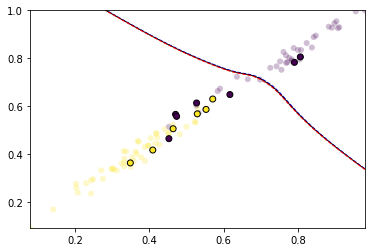

In [26]:
train_model(1000,X_train1,y_train1,polynomial_kernel)

17190.07646234499


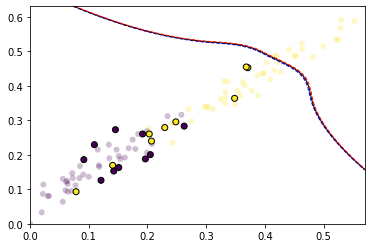

In [27]:
train_model(1000,X_train2,y_train2,polynomial_kernel)

85.5825378978646


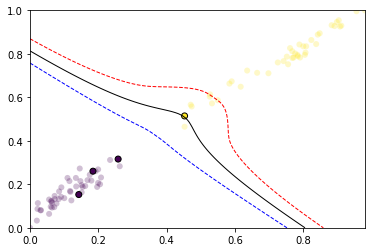

In [28]:
train_model(1000,X_train3,y_train3,polynomial_kernel)

116705.82575851877


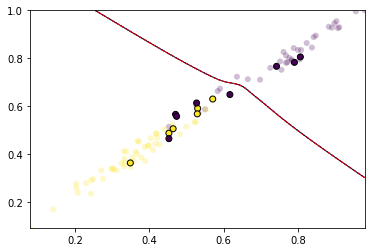

In [29]:
train_model(10000,X_train1,y_train1,gaussian_rbf_kernel)

140000.0


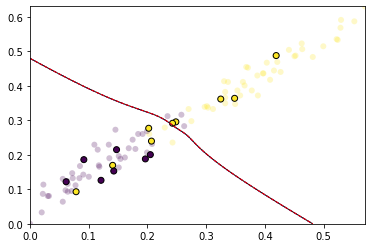

In [30]:
train_model(10000,X_train2,y_train2,gaussian_rbf_kernel)

85.5825378978646


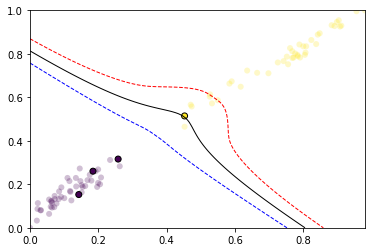

In [31]:
train_model(1000,X_train3,y_train3,gaussian_rbf_kernel)

1 v ALL classification

42000.0
14389.218038983792
16071.0638464454


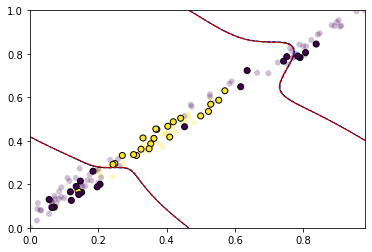

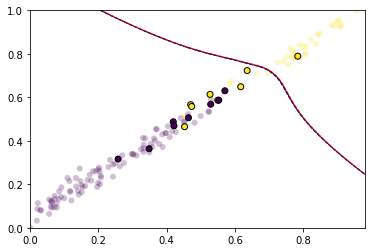

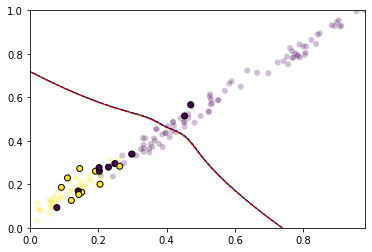

In [32]:
for i in range(3):  
    
    X = train.copy() #copy of the training samples
    for row in X:
        if row[-1] == i+1:
            row[-1] = 1
        else:
            row[-1] = -1  
    
    X_train=X[:,0:7]
    y_train=X[:,7]    
    train_model(1000,X_train,y_train,polynomial_kernel) 

42000.0
14389.218038983792
16071.0638464454


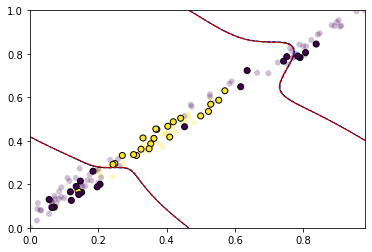

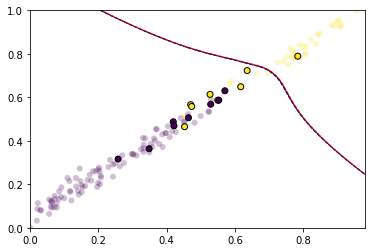

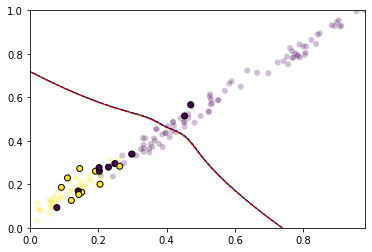

In [33]:
for i in range(3):  
    
    X = train.copy() #copy of the training samples
    for row in X:
        if row[-1] == i+1:
            row[-1] = 1
        else:
            row[-1] = -1  
    
    X_train=X[:,0:7]
    y_train=X[:,7]    
    train_model(1000,X_train,y_train,gaussian_rbf_kernel) 